## Vehicle Detection

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

c:\users\pavel simo\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
@interact(pix_per_cell=widgets.SelectionSlider(options=[8, 16], value=8),
          cell_per_block=widgets.SelectionSlider(options=[1, 2, 3], value=2))
def hog_show(pix_per_cell, cell_per_block):
    filenames = glob.glob('examples/hog/*.png')
    for index, filename in enumerate(filenames):
        img = mpimg.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        

        fig = plt.figure(figsize=(16, 3), dpi=80)
        
        # HOG
        plt.subplot(171)
        plt.imshow(img)
        plt.title('Example #%d' % (index + 1))
        for index, orient in enumerate([5, 6, 7, 8, 9, 10]):
            plt.subplot(172 + index)
            features, hog_image = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, feature_vec=False)
            plt.imshow(hog_image, cmap='gray')
            plt.title('HOG orient=%d' % orient)                    

interactive(children=(SelectionSlider(description='pix_per_cell', options=(8, 16), value=8), SelectionSlider(d…

In [3]:
@interact(nbins=widgets.SelectionSlider(options=[8, 16, 32, 64, 128], value=8))
def hist_show(nbins):
    for color_space in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
        filenames = glob.glob('examples/hog/*.png')[:2]
        for index, filename in enumerate(filenames):         
            fig = plt.figure(figsize=(16, 3), dpi=80)
            img = cv2.imread(filename)            

            if color_space == 'RGB':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif color_space == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)       
            elif color_space == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)                       

            bins_range = (0, 256)
            c1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
            c2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
            c3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
            bin_edges = c1[1]
            bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

            plt.subplot(141)
            plt.imshow(img, aspect="auto")
            plt.title('%s #%d' % (color_space, index + 1))        

            plt.subplot(142)
            plt.bar(bin_centers, c1[0])
            plt.xlim(bins_range[0], bins_range[1])
            plt.title('Channel 1')       

            plt.subplot(143)
            plt.bar(bin_centers, c2[0])
            plt.xlim(bins_range[0], bins_range[1])
            plt.title('Channel 2')       

            plt.subplot(144)
            plt.bar(bin_centers, c3[0])
            plt.xlim(bins_range[0], bins_range[1])
            plt.title('Channel 3')   

interactive(children=(SelectionSlider(description='nbins', options=(8, 16, 32, 64, 128), value=8), Output()), …

In [4]:
from scipy.misc import imsave  
import os

# Read in cars and notcars
filenames = glob.glob('train_images/**/*.png', recursive=True)
cars = []
notcars = []
for filename in filenames:
    if 'non-vehicles' in filename:
        notcars.append(filename)
    else:
        cars.append(filename)

# augumenting the data        
# for index, filename in enumerate(cars):
#     flipped = mpimg.imread(filename)
#     flipped = flipped[:, ::-1]
#     basedir = r'/path/to/extra'
#     new_filename = os.path.join(basedir, 'image%0000d.png' % index)
#     imsave(new_filename, flipped)    

print('Number of cars samples %d' % len(cars))
print('Number of non-cars samples %d' % len(notcars))

sample_size = min(len(cars), len(notcars))
print('Sample size %d' % sample_size)
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

Number of cars samples 35196
Number of non-cars samples 17894
Sample size 17894


In [5]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, 656] # Min and max in y to search in slide_window()
scale = 1.5

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

del X
del y

In [7]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [8]:
import time
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
16.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9939


In [9]:
image = mpimg.imread('test_images/test1.jpg')

In [10]:
def find_vehicles(img, y_start_stop=y_start_stop, scale=scale, svc=svc, X_scaler=X_scaler, 
                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                   spatial_size=spatial_size, hist_bins=hist_bins, visualize=False, 
                   visualize_grid=False, bbox_color=(0,0,255)):
    """ Define a single function that can extract features using hog sub-sampling and make predictions """
    
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)


            if visualize_grid or test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)            
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img, bbox[0], bbox[1],bbox_color,6)                 
                box_list.append(bbox)
    
    if visualize:
        return box_list, draw_img    
    return box_list    

2
3
3
3


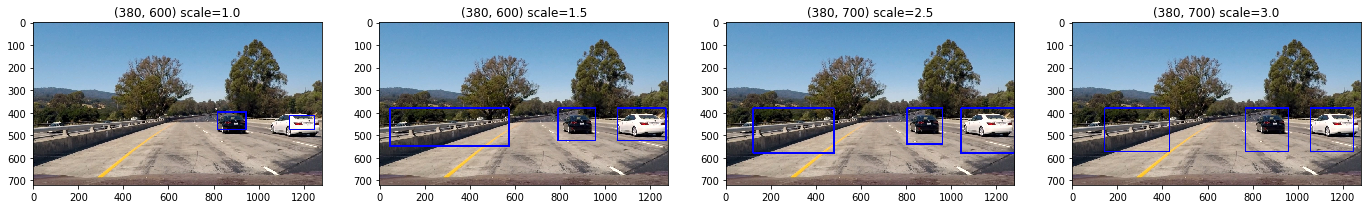

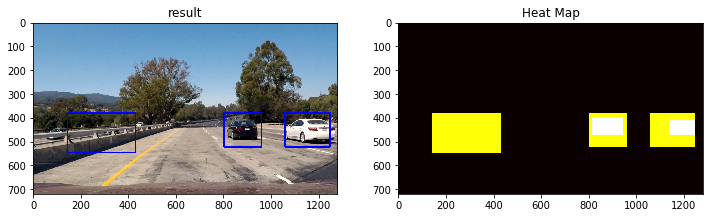

0
0
0
1


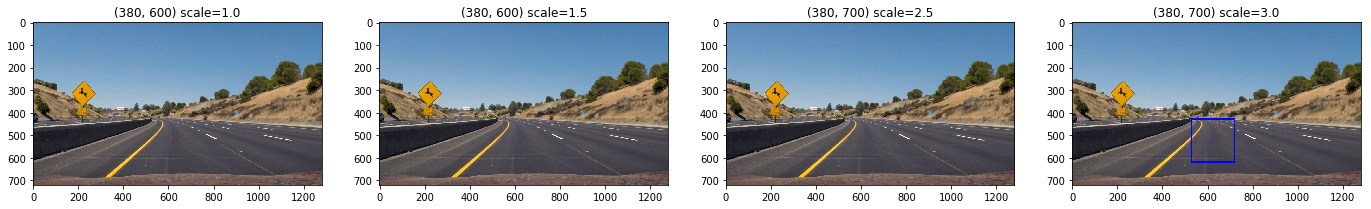

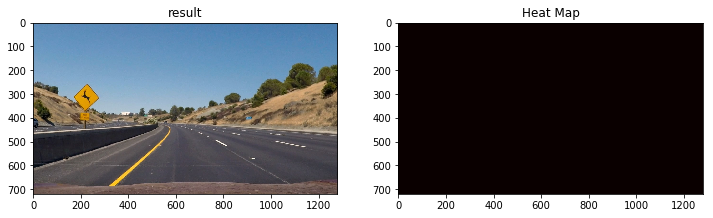

1
1
0
0


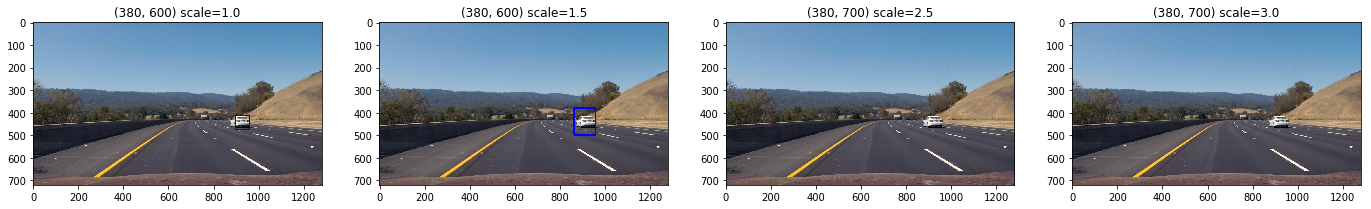

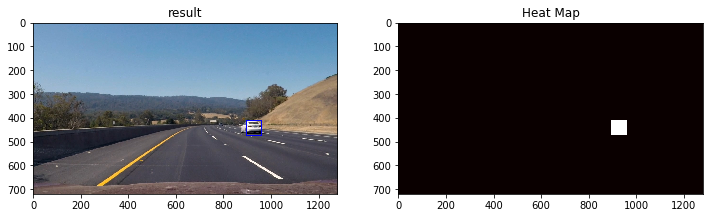

2
4
3
4


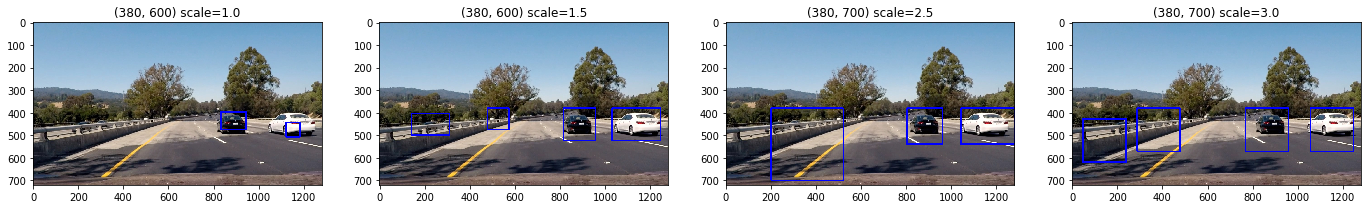

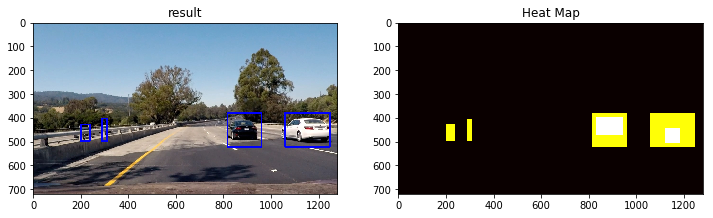

2
3
3
3


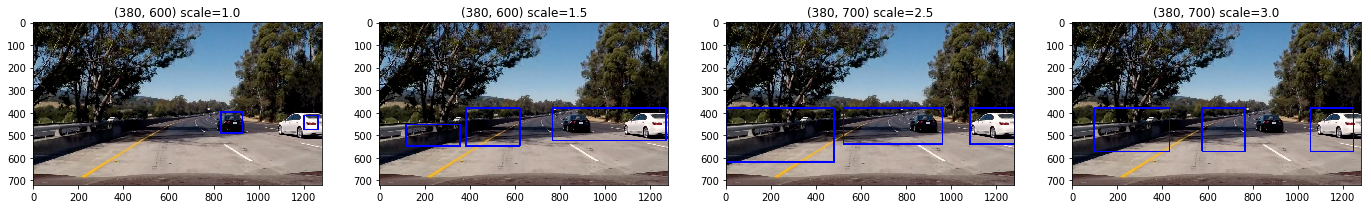

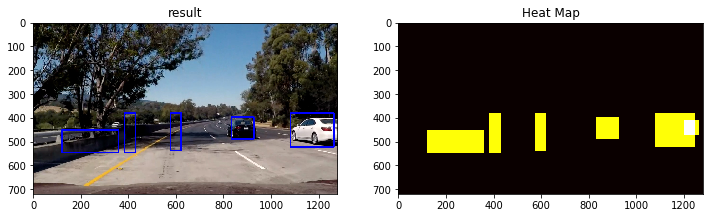

2
3
3
1


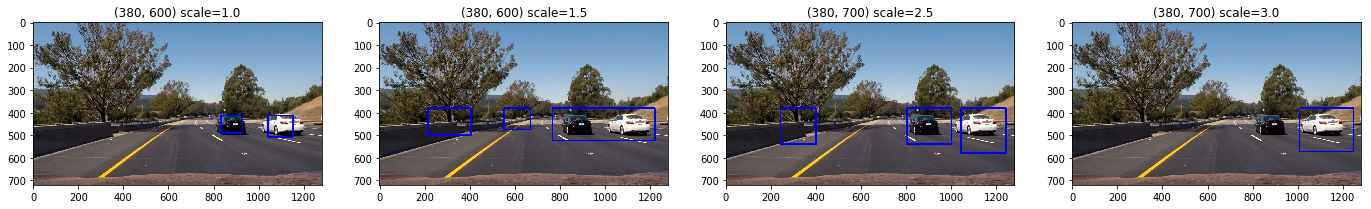

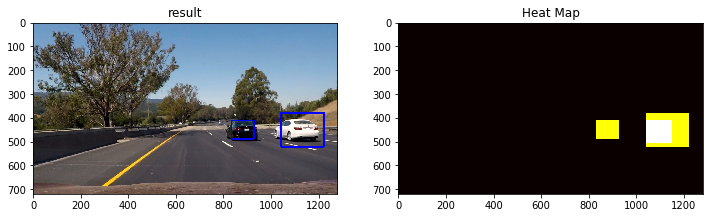

1
1
2
1


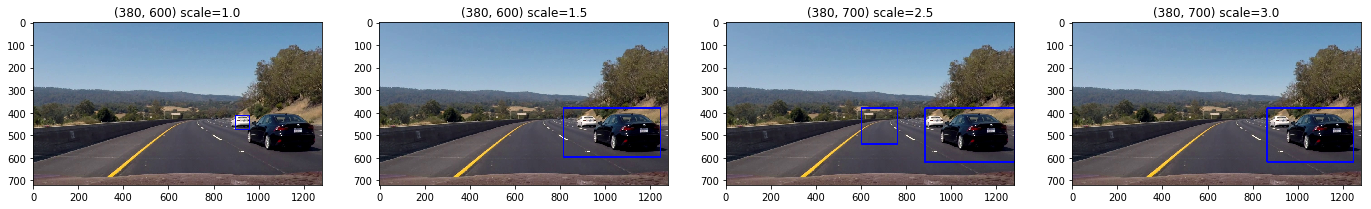

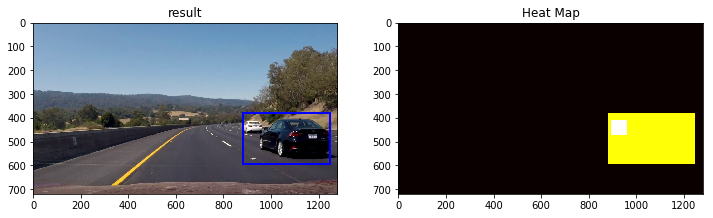

In [11]:
  
def add_heat(heatmap, bbox_list, scale=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += scale

    # Return updated heatmap
    # Iterate through list of bboxes
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
      # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        boxes.append(bbox)
    # Return the image
    return img, boxes    

filenames = glob.glob('test_images/**/*.jpg', recursive=True)
for filename in filenames:
    box_list = []
    image = mpimg.imread(filename)
    fig = plt.figure(figsize=(30, 8))        
    k = 151
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255, 0, 255)]               
    windows = [(380, 600, 1), (380, 600, 1.5), (380, 700, 2.5), (380, 700, 3.0)]
    threshold = 0
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for ystart, ystop, scale in windows:
        
        plt.subplot(k)
        boxes, img_out = find_vehicles(image, y_start_stop=(ystart, ystop), scale=scale, visualize=True, 
                                       visualize_grid=False, bbox_color=colors[k % len(colors)])
        cur_heat = np.zeros_like(image[:,:,0]).astype(np.float)
        cur_heat = add_heat(cur_heat, boxes)
        cur_heatmap = np.clip(cur_heat, 0, 255)
        cur_labels = label(cur_heatmap)            
        draw_img, label_boxes = draw_labeled_bboxes(np.copy(image), cur_labels)             
        
        
        if len(label_boxes) > 0:
            threshold += 1
        print(len(label_boxes))    
        
        heat = add_heat(heat, label_boxes)
        #plt.imshow(img_out)
        plt.imshow(draw_img)
        plt.title('(%d, %d) scale=%.1f' % (ystart, ystop, scale))
        k += 1
    
    heat = apply_threshold(heat, max(1, threshold // 2))   
    #values = np.unique(heat[np.nonzero(heat)])
    #print(values)
    #threshold = 2
    #heat = apply_threshold(heat, threshold)        

    heatmap = np.clip(heat, 0, 255)
    plt.show()
    # Find final boxes from heatmap using label function
    
    labels = label(heatmap)
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    draw_img, _ = draw_labeled_bboxes(np.copy(image), labels)
    plt.imshow(draw_img)
    plt.title('result')        
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.show()

In [12]:
class VehicleDetection(object):
    
    def __init__(self):
        self.frame_num = 0
        self.frame_threshold = 20
        #self.boxes = [[]] * self.frame_threshold
        self.frames = [None] * self.frame_threshold
        self.windows = [(400, 600, 1), (400, 600, 1.5), (400, 700, 2.5)]
    
    def add_heat(self, heatmap, bbox_list, scale=1):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += scale

        # Return updated heatmap
        # Iterate through list of bboxes
        return heatmap

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        boxes = []
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            boxes.append(bbox)
        # Return the image
        return img, boxes    
  
    def apply_heatmap(self, image):
        
        threshold = 0        
        box_list = []
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        for ystart, ystop, scale in self.windows:
            boxes = find_vehicles(image, y_start_stop=(ystart, ystop), scale=scale)
            cur_heat = np.zeros_like(image[:,:,0]).astype(np.float)
            cur_heat = add_heat(cur_heat, boxes)
            cur_heatmap = np.clip(cur_heat, 0, 255)
            cur_labels = label(cur_heatmap)
            _, label_boxes = self.draw_labeled_bboxes(np.copy(image), cur_labels)                         
            
            if len(label_boxes) > 0:
                threshold += 1            
            
            heat = add_heat(heat, label_boxes)        
        
        heat = apply_threshold(heat, max(1, threshold // 2))
        self.frames[self.frame_num % self.frame_threshold] = heat
        
        if self.frame_num >= self.frame_threshold:                        
            heat = np.mean(self.frames, axis=0)
            heat = apply_threshold(heat, 1)
        
        heatmap = np.clip(heat, 0, 255)                    
        # Find final boxes from heatmap using label function
        labels = label(heatmap)            
        draw_img, label_boxes = self.draw_labeled_bboxes(np.copy(image), labels)     
              
        return draw_img

#     def apply_heatmap(self, image):
#         heat = np.zeros_like(image[:,:,0]).astype(np.float)
                        
#         # Creating the box list
#         boxes = []
        
#         for ystart, ystop, scale in [(400, 600, 1), (400, 500, 1.5), (500, 700, 2.5)]:
#             bbox = find_vehicles(image, y_start_stop=(ystart, ystop), scale=scale)
#             boxes.extend(bbox)
        
#         # Add heat to each box in box list
#         if self.frame_num < self.frame_threshold:            
#             heat = self.add_heat(heat, boxes) 
#             heat = self.apply_threshold(heat, 1)
#         else:
#             for bbox_list in self.boxes:
#                 heat = self.add_heat(heat, bbox_list)                                  
#                 heat = self.apply_threshold(heat, 1)
        
#         self.boxes[self.frame_num % self.frame_threshold] = boxes
        
#         # Visualize the heatmap when displaying    
#         heatmap = np.clip(heat, 0, 255)    

#         # Find final boxes from heatmap using label function
#         labels = label(heatmap)            
#         draw_img, label_boxes = self.draw_labeled_bboxes(np.copy(image), labels)                
                
#         return draw_img

    def render(self, image):
        # keeping the last boxes
        result = self.apply_heatmap(image)
        self.frame_num += 1
        return result

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
#clip = VideoFileClip('test_video.mp4')
clip = VideoFileClip('project_video.mp4')

vd = VehicleDetection()
def pipeline(img):
    return vd.render(img)

new_clip = clip.fl_image(pipeline)
new_clip.write_videofile('result.mp4')

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing audio in resultTEMP_MPY_wvf_snd.mp3




  0%|          | 0/1112 [00:00<?, ?it/s]

 20%|██        | 224/1112 [00:00<00:00, 1978.81it/s]

 48%|████▊     | 538/1112 [00:00<00:00, 2154.93it/s]

 73%|███████▎  | 815/1112 [00:00<00:00, 2298.36it/s]

100%|██████████| 1112/1112 [00:00<00:00, 2592.27it/s]

[MoviePy] Done.
[MoviePy] Writing video result.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<22:27,  1.07s/it]

  0%|          | 2/1261 [00:02<22:36,  1.08s/it]

  0%|          | 3/1261 [00:03<22:33,  1.08s/it]

  0%|          | 4/1261 [00:04<23:11,  1.11s/it]

  0%|          | 5/1261 [00:05<23:05,  1.10s/it]

  0%|          | 6/1261 [00:06<22:57,  1.10s/it]

  1%|          | 7/1261 [00:07<22:59,  1.10s/it]

  1%|          | 8/1261 [00:08<22:53,  1.10s/it]

  1%|          | 9/1261 [00:09<23:03,  1.10s/it]

  1%|          | 10/1261 [00:10<22:50,  1.10s/it]

  1%|          | 11/1261 [00:12<22:46,  1.09s/it]

  1%|          | 12/1261 [00:13<22:44,  1.09s/it]

  1%|          | 13/1261 [00:14<22:58,  1.10s/it]

  1%|          | 14/1261 [00:15<23:07,  1.11s/it]

  1%|          | 15/1261 [00:16<23:04,  1.11s/it]

  1%|▏         | 16/1261 [00:17<22:50,  1.10s/it]

  1%|▏         | 17/1261 [00:18<22:43,  1.10s/it]

  1%|▏         | 18/1261 [00:19<22:36,  1.09s/it]

  2%|▏         | 19/1261 [00:20<22:40,  1.10s/i

 13%|█▎        | 159/1261 [03:04<21:32,  1.17s/it]

 13%|█▎        | 160/1261 [03:05<21:28,  1.17s/it]

 13%|█▎        | 161/1261 [03:07<21:22,  1.17s/it]

 13%|█▎        | 162/1261 [03:08<21:20,  1.17s/it]

 13%|█▎        | 163/1261 [03:09<21:17,  1.16s/it]

 13%|█▎        | 164/1261 [03:10<21:16,  1.16s/it]

 13%|█▎        | 165/1261 [03:11<21:17,  1.17s/it]

 13%|█▎        | 166/1261 [03:12<21:10,  1.16s/it]

 13%|█▎        | 167/1261 [03:14<21:09,  1.16s/it]

 13%|█▎        | 168/1261 [03:15<21:25,  1.18s/it]

 13%|█▎        | 169/1261 [03:16<22:15,  1.22s/it]

 13%|█▎        | 170/1261 [03:17<22:07,  1.22s/it]

 14%|█▎        | 171/1261 [03:19<22:02,  1.21s/it]

 14%|█▎        | 172/1261 [03:20<22:04,  1.22s/it]

 14%|█▎        | 173/1261 [03:21<22:14,  1.23s/it]

 14%|█▍        | 174/1261 [03:22<22:09,  1.22s/it]

 14%|█▍        | 175/1261 [03:23<21:53,  1.21s/it]

 14%|█▍        | 176/1261 [03:25<21:43,  1.20s/it]

 14%|█▍        | 177/1261 [03:26<21:30,  1.19s/it]

 14%|█▍     

 25%|██▌       | 316/1261 [06:09<18:46,  1.19s/it]

 25%|██▌       | 317/1261 [06:10<19:00,  1.21s/it]

 25%|██▌       | 318/1261 [06:12<18:50,  1.20s/it]

 25%|██▌       | 319/1261 [06:13<18:41,  1.19s/it]

 25%|██▌       | 320/1261 [06:14<18:47,  1.20s/it]

 25%|██▌       | 321/1261 [06:15<18:38,  1.19s/it]

 26%|██▌       | 322/1261 [06:16<18:33,  1.19s/it]

 26%|██▌       | 323/1261 [06:18<18:38,  1.19s/it]

 26%|██▌       | 324/1261 [06:19<18:30,  1.18s/it]

 26%|██▌       | 325/1261 [06:20<18:40,  1.20s/it]

 26%|██▌       | 326/1261 [06:21<18:35,  1.19s/it]

 26%|██▌       | 327/1261 [06:22<18:35,  1.19s/it]

 26%|██▌       | 328/1261 [06:23<18:31,  1.19s/it]

 26%|██▌       | 329/1261 [06:25<18:36,  1.20s/it]

 26%|██▌       | 330/1261 [06:26<18:27,  1.19s/it]

 26%|██▌       | 331/1261 [06:27<18:32,  1.20s/it]

 26%|██▋       | 332/1261 [06:28<18:33,  1.20s/it]

 26%|██▋       | 333/1261 [06:29<18:22,  1.19s/it]

 26%|██▋       | 334/1261 [06:31<18:22,  1.19s/it]

 27%|██▋    

 38%|███▊      | 473/1261 [09:16<15:33,  1.18s/it]

 38%|███▊      | 474/1261 [09:17<15:32,  1.18s/it]

 38%|███▊      | 475/1261 [09:18<15:41,  1.20s/it]

 38%|███▊      | 476/1261 [09:19<15:52,  1.21s/it]

 38%|███▊      | 477/1261 [09:21<15:38,  1.20s/it]

 38%|███▊      | 478/1261 [09:22<15:44,  1.21s/it]

 38%|███▊      | 479/1261 [09:23<15:43,  1.21s/it]

 38%|███▊      | 480/1261 [09:24<15:32,  1.19s/it]

 38%|███▊      | 481/1261 [09:25<15:44,  1.21s/it]

 38%|███▊      | 482/1261 [09:27<15:31,  1.20s/it]

 38%|███▊      | 483/1261 [09:28<15:22,  1.19s/it]

 38%|███▊      | 484/1261 [09:29<15:25,  1.19s/it]

 38%|███▊      | 485/1261 [09:30<15:18,  1.18s/it]

 39%|███▊      | 486/1261 [09:31<15:21,  1.19s/it]

 39%|███▊      | 487/1261 [09:32<15:18,  1.19s/it]

 39%|███▊      | 488/1261 [09:34<15:11,  1.18s/it]

 39%|███▉      | 489/1261 [09:35<15:06,  1.17s/it]

 39%|███▉      | 490/1261 [09:36<15:03,  1.17s/it]

 39%|███▉      | 491/1261 [09:37<15:00,  1.17s/it]

 39%|███▉   

 50%|████▉     | 630/1261 [12:22<12:36,  1.20s/it]

 50%|█████     | 631/1261 [12:23<12:27,  1.19s/it]

 50%|█████     | 632/1261 [12:24<12:19,  1.18s/it]

 50%|█████     | 633/1261 [12:26<12:27,  1.19s/it]

 50%|█████     | 634/1261 [12:27<12:27,  1.19s/it]

 50%|█████     | 635/1261 [12:28<12:19,  1.18s/it]

 50%|█████     | 636/1261 [12:29<12:14,  1.18s/it]

 51%|█████     | 637/1261 [12:30<12:10,  1.17s/it]

 51%|█████     | 638/1261 [12:31<12:10,  1.17s/it]

 51%|█████     | 639/1261 [12:33<12:10,  1.17s/it]

 51%|█████     | 640/1261 [12:34<12:13,  1.18s/it]

 51%|█████     | 641/1261 [12:35<12:07,  1.17s/it]

 51%|█████     | 642/1261 [12:36<12:27,  1.21s/it]

 51%|█████     | 643/1261 [12:37<12:15,  1.19s/it]

 51%|█████     | 644/1261 [12:39<12:07,  1.18s/it]

 51%|█████     | 645/1261 [12:40<12:02,  1.17s/it]

 51%|█████     | 646/1261 [12:41<12:17,  1.20s/it]

 51%|█████▏    | 647/1261 [12:42<12:11,  1.19s/it]

 51%|█████▏    | 648/1261 [12:43<12:12,  1.19s/it]

 51%|█████▏ 

 62%|██████▏   | 787/1261 [15:28<09:17,  1.18s/it]

 62%|██████▏   | 788/1261 [15:30<09:14,  1.17s/it]

 63%|██████▎   | 789/1261 [15:31<09:22,  1.19s/it]

 63%|██████▎   | 790/1261 [15:32<09:21,  1.19s/it]

 63%|██████▎   | 791/1261 [15:33<09:33,  1.22s/it]

 63%|██████▎   | 792/1261 [15:34<09:24,  1.20s/it]

 63%|██████▎   | 793/1261 [15:36<09:17,  1.19s/it]

 63%|██████▎   | 794/1261 [15:37<09:16,  1.19s/it]

 63%|██████▎   | 795/1261 [15:38<09:11,  1.18s/it]

 63%|██████▎   | 796/1261 [15:39<09:07,  1.18s/it]

 63%|██████▎   | 797/1261 [15:40<09:04,  1.17s/it]

 63%|██████▎   | 798/1261 [15:41<09:02,  1.17s/it]

 63%|██████▎   | 799/1261 [15:43<09:02,  1.17s/it]

 63%|██████▎   | 800/1261 [15:44<09:04,  1.18s/it]

 64%|██████▎   | 801/1261 [15:45<09:00,  1.17s/it]

 64%|██████▎   | 802/1261 [15:46<09:00,  1.18s/it]

 64%|██████▎   | 803/1261 [15:47<09:04,  1.19s/it]

 64%|██████▍   | 804/1261 [15:49<09:00,  1.18s/it]

 64%|██████▍   | 805/1261 [15:50<09:01,  1.19s/it]

 64%|██████▍

 75%|███████▍  | 944/1261 [18:35<06:22,  1.21s/it]

 75%|███████▍  | 945/1261 [18:36<06:21,  1.21s/it]

 75%|███████▌  | 946/1261 [18:37<06:18,  1.20s/it]

 75%|███████▌  | 947/1261 [18:38<06:14,  1.19s/it]

 75%|███████▌  | 948/1261 [18:40<06:16,  1.20s/it]

 75%|███████▌  | 949/1261 [18:41<06:15,  1.20s/it]

 75%|███████▌  | 950/1261 [18:42<06:14,  1.20s/it]

 75%|███████▌  | 951/1261 [18:43<06:09,  1.19s/it]

 75%|███████▌  | 952/1261 [18:44<06:06,  1.19s/it]

 76%|███████▌  | 953/1261 [18:45<06:03,  1.18s/it]

 76%|███████▌  | 954/1261 [18:47<06:03,  1.18s/it]

 76%|███████▌  | 955/1261 [18:48<06:05,  1.20s/it]

 76%|███████▌  | 956/1261 [18:49<06:01,  1.19s/it]

 76%|███████▌  | 957/1261 [18:50<06:03,  1.20s/it]

 76%|███████▌  | 958/1261 [18:51<06:02,  1.20s/it]

 76%|███████▌  | 959/1261 [18:53<06:05,  1.21s/it]

 76%|███████▌  | 960/1261 [18:54<06:01,  1.20s/it]

 76%|███████▌  | 961/1261 [18:55<05:57,  1.19s/it]

 76%|███████▋  | 962/1261 [18:56<05:55,  1.19s/it]

 76%|███████

 87%|████████▋ | 1099/1261 [21:41<03:13,  1.19s/it]

 87%|████████▋ | 1100/1261 [21:42<03:10,  1.19s/it]

 87%|████████▋ | 1101/1261 [21:43<03:09,  1.19s/it]

 87%|████████▋ | 1102/1261 [21:44<03:09,  1.19s/it]

 87%|████████▋ | 1103/1261 [21:46<03:10,  1.21s/it]

 88%|████████▊ | 1104/1261 [21:47<03:08,  1.20s/it]

 88%|████████▊ | 1105/1261 [21:48<03:06,  1.19s/it]

 88%|████████▊ | 1106/1261 [21:49<03:03,  1.19s/it]

 88%|████████▊ | 1107/1261 [21:50<03:03,  1.19s/it]

 88%|████████▊ | 1108/1261 [21:52<03:01,  1.19s/it]

 88%|████████▊ | 1109/1261 [21:53<03:02,  1.20s/it]

 88%|████████▊ | 1110/1261 [21:54<03:02,  1.21s/it]

 88%|████████▊ | 1111/1261 [21:55<02:59,  1.20s/it]

 88%|████████▊ | 1112/1261 [21:56<02:58,  1.20s/it]

 88%|████████▊ | 1113/1261 [21:58<02:56,  1.19s/it]

 88%|████████▊ | 1114/1261 [21:59<02:54,  1.19s/it]

 88%|████████▊ | 1115/1261 [22:00<02:53,  1.19s/it]

 89%|████████▊ | 1116/1261 [22:01<02:51,  1.18s/it]

 89%|████████▊ | 1117/1261 [22:02<02:51,  1.19

 99%|█████████▉| 1253/1261 [24:46<00:09,  1.19s/it]

 99%|█████████▉| 1254/1261 [24:47<00:08,  1.20s/it]

100%|█████████▉| 1255/1261 [24:48<00:07,  1.19s/it]

100%|█████████▉| 1256/1261 [24:49<00:05,  1.18s/it]

100%|█████████▉| 1257/1261 [24:50<00:04,  1.22s/it]

100%|█████████▉| 1258/1261 [24:52<00:03,  1.21s/it]

100%|█████████▉| 1259/1261 [24:53<00:02,  1.20s/it]

100%|█████████▉| 1260/1261 [24:54<00:01,  1.23s/it]



[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [19]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))